# Recommender system for La Fourchette

We try in this notebook to implement a recommender system for the mobile app La Fourchette. La Fourchette allows its users to find restaurant near their position and to reserve easily a table. The users are able to evaluate their experience. A user can give several grades. For example "cooking", "surroudings", "service". 
It is also possible to consider some metadata such as the hour, and the distance. 

The first thing we need is data. We will generate random users and items. There are several ways to do this:
- We can chose users, items and metadata uniformly
- Or we can define several clusters and chose random users/items/metadata in these clusters

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as mplt
from tqdm import tqdm_notebook

from user import *
from restaurant import *
from environment import *
from agents import *

Using TensorFlow backend.
/home/jules/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jules/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jules/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jules/anaconda3/lib/python3.7/site-packages/tensorflo

In [2]:
restaurants, sp_dict = Restaurant.load_from_csv("./data/restaurants.csv", set_random_params=False)

In [3]:
def run_exp(n_restaurants, n_users, agent, n_iterations, n_exp=1, seed=None):
    rewards = []
    users_selected = []
    restaurants_selected = []
    cum_rewards = []
    
    for exp in tqdm_notebook(range(n_exp)):
        global restaurants
        restaurants = restaurants[0:n_restaurants]
        
        if seed is not None:
            users = [User(seed + i) for i in range(n_users)]
            env = Environment(users, restaurants, agent, seed=seed+n_users+exp)
        else:
            users = [User() for i in range(n_users)]
            env = Environment(users, restaurants, agent)
            
        env.reset(sp_dict)

        for i in tqdm_notebook(range(n_iterations)):
            user, rest, reward = env.step()
            rewards.append(reward)
            users_selected.append(user)
            restaurants_selected.append(rest)
        cum_rewards.append(env.get_cum_reward())
    return cum_rewards, rewards, users_selected, restaurants_selected

In [4]:
def draw_regret(rewards):
    regret = [max_reward - reward for reward, max_reward in rewards]
    
    min_regret = np.min(regret, axis=0)
    max_regret = np.max(regret, axis=0)
    mean_regret = np.mean(regret, axis=0)
    
    mplt.title("Regret (mean regret {})".format(mean_regret[-1]))
    mplt.plot(min_regret)
    mplt.plot(max_regret)
    mplt.plot(mean_regret)

In [17]:
cr, r, u, rest = run_exp(100, 20, ContextualEpsilonGreedyAgent(100, 343), n_iterations=20000, n_exp=1, seed=2020)

In [18]:
history = np.array([u, rest, r])

In [19]:
deepAgent = DeepAgent(100, 20, 1)
deepAgent.fit(history)

In [20]:
cr, r, u, rest = run_exp(100, 20, deepAgent, n_iterations=500, n_exp=10)

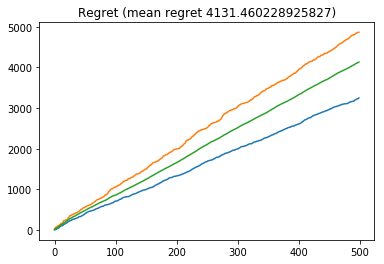

In [21]:
draw_regret(cr)

In [58]:
r4 = run_exp(100, 20, RandomAgent(), n_iterations=500, n_exp=10, seed=2020)

In [59]:
r3 = run_exp(100, 20, ContextualEpsilonGreedyAgent(100, 343), n_iterations=500, n_exp=10, seed=2020)

In [35]:
a = np.array([0,0], dtype=np.bool)

array([ True,  True])

In [38]:
b = np.array([1,2])

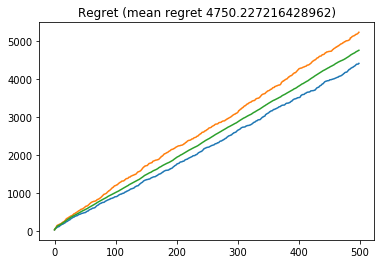

In [60]:
draw_regret(r4)

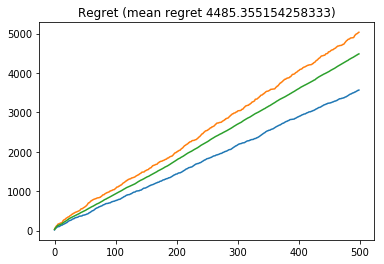

In [61]:
draw_regret(r3)

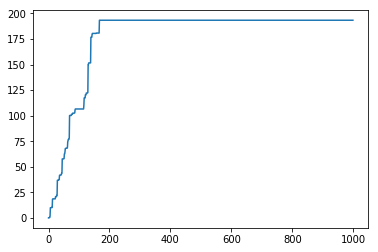

In [54]:
mplt.plot(r3[0][0])

array([0.        , 0.        , 0.        , ..., 2.86357248, 2.86357248,
       2.86357248])

In [17]:
r2 = run_exp(100, 2000, EpsGreedyAgent(100, 0.1), 100, 5, 2020)

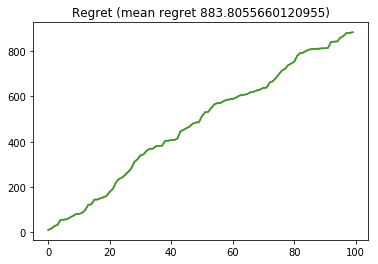

In [12]:
r3 = run_exp(10, 2000, UCBAgent(10), n_iterations=100, n_exp=5)

TypeError: must be real number, not NoneType

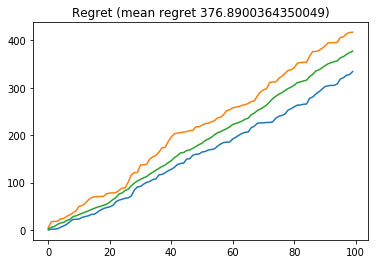

In [11]:
draw_regret(r3)

In [37]:
r3 = run_exp(100, 2000, RandomAgent(), n_iterations=50, n_exp=1, seed=2020)

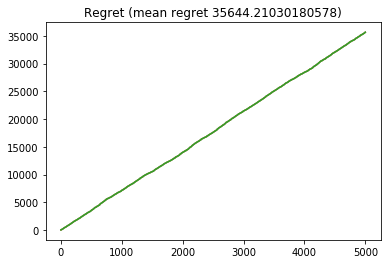

In [16]:
draw_regret(r3)

In [20]:
a[-len(b):] = b

In [21]:
users = [User() for i in range(100)]
for u in users:
    u.generate_random_params(restaurants, sp_dict)

In [ ]:
np.stack(a)

In [19]:
np.concatenate([[1,2], [2, 3]])

array([1, 2, 2, 3])

In [24]:
users[0].get_features_vec()

array([3. , 3. , 3. , 3. , 3. , 3. , 3. , 3. , 3. , 3. , 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. ])

TypeError: super(type, obj): obj must be an instance or subtype of type

In [40]:
len(restaurants[0].get_feature_vec())

172

In [41]:
len(users[0].get_feature_vec())

171